## Weaviate Setup

The CLIP model is only available with local Weaviate deployments with Docker or Kubernetes.

CLIP is not supported with Weaviate Cloud Services (WCS).

### Steps to deploy Weaviate locally with CLIP

1. Get a docker compose file.
    
    Run the following command in your terminal:

    ```
    curl -o docker-compose.yml "https://configuration.weaviate.io/v2/docker-compose/docker-compose.yml?clip_model=xlm-roberta-base-ViT-B-32-laion5b_s13b_b90k&generative_cohere=false&generative_openai=false&generative_palm=false&media_type=clip&modules=modules&ner_module=false&qna_module=false&ref2vec_centroid=false&reranker_cohere=false&reranker_transformers=false&runtime=docker-compose&spellcheck_module=false&sum_module=false&weaviate_version=v1.21.6&weaviate_volume=named-volume"
    ```

    This will download `docker-compose.yml` file for you.

2. Run Weaviate+CLIP with Docker Compose

    > If you are new to docker compose, [here are instructions on how to install it](https://docs.docker.com/compose/install/).

    To start the docker image defined in the `docker-compose.yml` file, call:

    ```
    docker compose up
    ```
    
    > Note #1 - the first time you run the command, Docker will download a ~3GB image.
    
    > Note #2 – to shut down a running docker image, press CMD+C or CTRL+C.

## Dependencies

In [ ]:
!pip install weaviate-client

## Configuration

In [207]:
import weaviate

client = weaviate.Client(
  url="http://localhost:8080",  # URL to your local Weaviate instance
)

client.is_ready() # Test the connection

True

### Create `Animals` collection

The collection has the following key characteristics:
1. Name: `"Animals"`
2. Vectorizer: `multi2vec-clip`
3. Image property: `"image"` - Weaviate will use values in "image" property to generate vectors. Note, you can call it anything you want.

In [233]:
if client.schema.exists("Animals"):
    client.schema.delete_class("Animals")

animals = {
    "classes": [
        {
            "class": "Animals",
            "vectorizer": "multi2vec-clip",
            "moduleConfig": {
                "multi2vec-clip": {
                    "textFields": ["name"],
                    "imageFields": ["image"],
                    "weights": {
                        "textFields": [0.01],
                        "imageFields": [0.99],
                    }
                }
            },
        }
    ]
}

client.schema.create(animals)
print("Successfully created Animals collection.")

Successfully created Animals collection.


### Import Images
For every image, we will store:
* `name` - the file name 
* `path` - path to the file, so that we could display returned images at query time.
* `file` - the client will convert the file to base64, and then Weaviate will use that to generate a vector - see `imageFields`.

In [ ]:
import base64
def toBase64(path):
    with open(path, 'rb') as content:
        return base64.b64encode(content).decode('utf-8')


In [234]:
source = ["cat1.jpg", "cat2.jpg", "cat3.jpg",
          "dog1.jpg", "dog2.jpg", "dog3.jpg",
          "meerkat1.jpg", "meerkat2.jpg", "meerkat3.jpg"]

with client.batch as batch:
    batch.batch_size=5

    for name in source:
    # Batch import all Questions
        print(f"Adding {name}")

        path = "./source/" + name

        # Object that we want to store in Weaviate
        properties = {
            # "name": name,
            "name": "Timon",
            "path": path,
            "file": toBase64(path), # Weaviate will use that the base64 representation of the file to generate a vector.
            # "file": path, # The client will convert the file to base64, and then Weaviate will use that to generate a vector - see `imageFields`.
            
        }

        client.batch.add_data_object(properties, "Animals")

Adding cat1.jpg
Adding cat2.jpg
Adding cat3.jpg
Adding dog1.jpg
Adding dog2.jpg
Adding dog3.jpg
Adding meerkat1.jpg
Adding meerkat2.jpg
Adding meerkat3.jpg


In [229]:
client.query.aggregate("Animals").with_meta_count().do()

{'data': {'Aggregate': {'Animals': [{'meta': {'count': 9}}]}}}

## Query examples

In [205]:
# Helper function to display results in a more readable fashion
import json
def json_print(data):
    print(json.dumps(data, indent=2))

### Image to Image search

[
  {
    "name": "Timon",
    "path": "./source/cat1.jpg"
  },
  {
    "name": "Timon",
    "path": "./source/cat2.jpg"
  },
  {
    "name": "Timon",
    "path": "./source/dog1.jpg"
  }
]


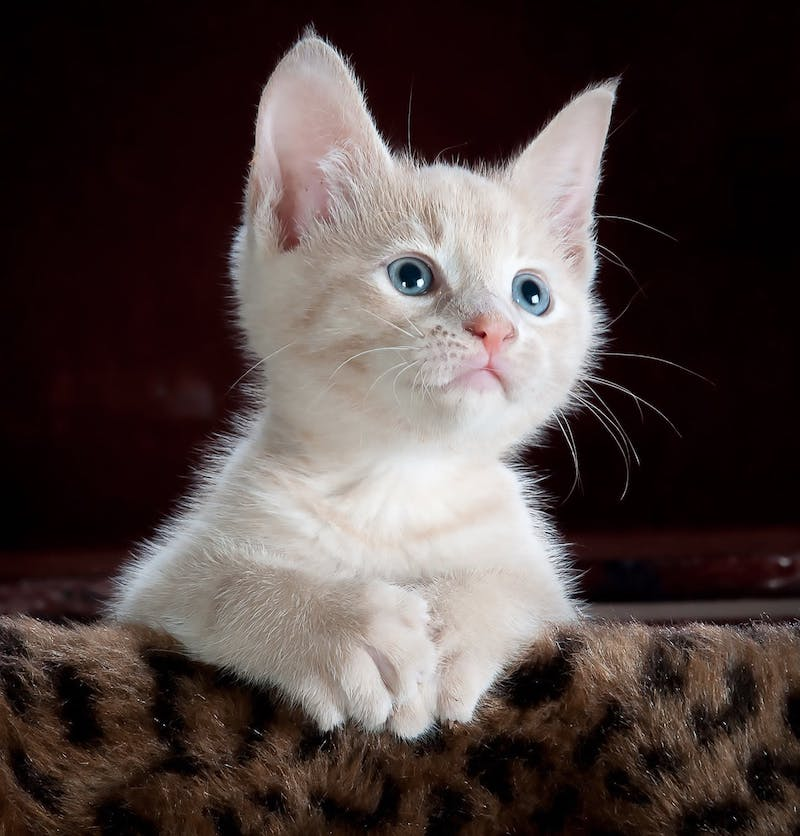

In [235]:
response = (
    client.query
    .get("Animals", "name path")
    .with_near_image(
        # {"image": "./test/test-dog.jpg"}, # Use file path as the input for the query
        # {"image": "./test/test-cat.jpg"}, # Use file path as the input for the query
        {"image": "./test/test-meerkat.jpg"}, # Use file path as the input for the query
    )
    .with_limit(3)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]
json_print(result)

# Display the first image
Image.open(result[0]["path"])

### Text to Image search

[
  {
    "name": "",
    "path": "./source/cat1.jpg"
  },
  {
    "name": "",
    "path": "./source/cat2.jpg"
  },
  {
    "name": "",
    "path": "./source/cat3.jpg"
  }
]


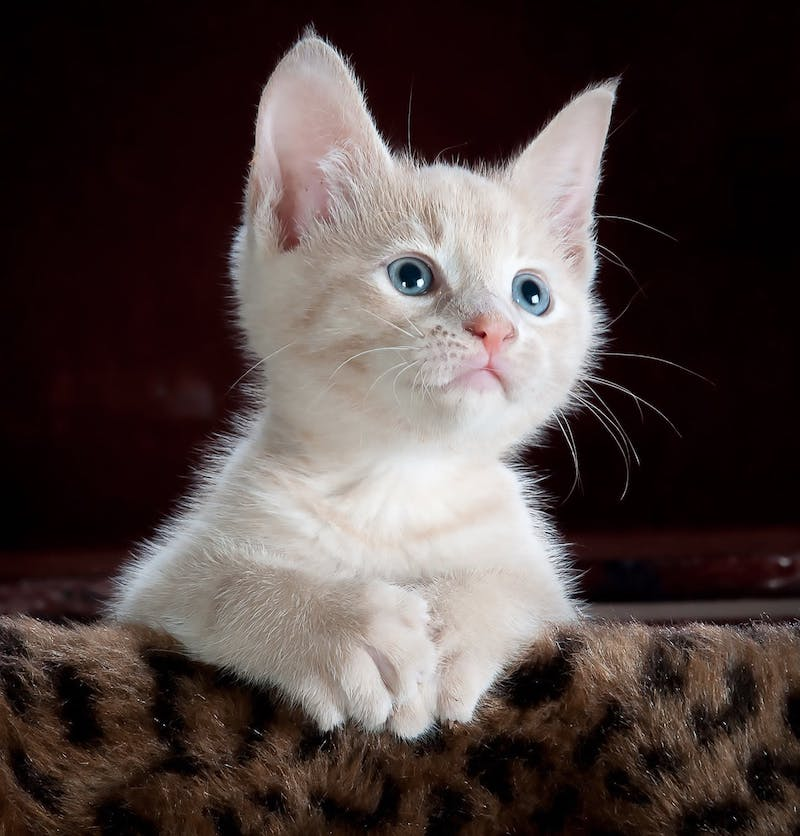

In [215]:
response = (
    client.query
    .get("Animals", "name path")
    .with_near_text(
        {"concepts": "dog"}
    )
    .with_limit(3)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]
json_print(result)

# Display the first image
Image.open(result[0]["path"])

### Multi-lingual Text to Image search

[
  {
    "_additional": {
      "distance": 0.41886526
    },
    "name": "Timon",
    "path": "./source/cat1.jpg"
  },
  {
    "_additional": {
      "distance": 0.41886526
    },
    "name": "Timon",
    "path": "./source/cat2.jpg"
  },
  {
    "_additional": {
      "distance": 0.41886526
    },
    "name": "Timon",
    "path": "./source/dog1.jpg"
  }
]


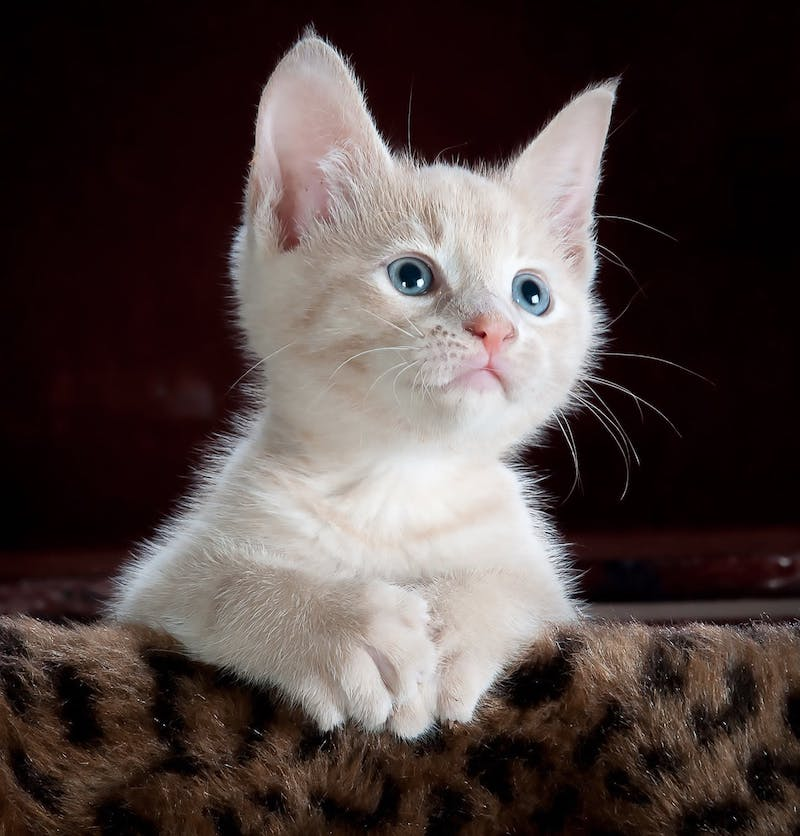

In [236]:
response = (
    client.query
    .get("Animals", "name path")
    .with_near_text(
        # {"concepts": "dog with a label"}
        # {"concepts": "pies ze znakiem"}
        # {"concepts": "perro con una etiqueta"}
        {"concepts": "meerkat"}
    )
    .with_additional("distance")
    .with_limit(3)
    .do()
)

# Print results
result = response["data"]["Get"]["Animals"]
json_print(result)

# Display the first image
Image.open(result[0]["path"])